# Data Cleaning and Exploration

## Overview
Processing NamUs data for missing persons and unidentified bodies across all US states and territories.

**Data sources:**
- NamUs (National Missing & Unidentified Persons System)
- 54 states/territories
- Date range: 1924-2025 (101 years)

**Key challenges:**
1. State name standardization (full names vs abbreviations)
2. Mixed file types (some CSVs contain both MP and UP data)
3. Date parsing across different formats
4. Duplicate detection

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

RAW_DIR = '../data/raw'

## 1. Data Loading

Load all state files - separate missing persons from unidentified bodies

In [2]:
# Load all missing persons files
mp_files = [f for f in os.listdir(RAW_DIR) if f.endswith('_missing_persons.csv')]
mp_data = []

for file in mp_files:
    df = pd.read_csv(os.path.join(RAW_DIR, file))
    mp_data.append(df)
    
df_mp = pd.concat(mp_data, ignore_index=True)

print(f"Missing Persons: {len(df_mp):,} cases across {len(mp_files)} states")
print(f"Columns: {df_mp.columns.tolist()}")

Missing Persons: 25,743 cases across 55 states
Columns: ['Case Number', 'DLC', 'Legal Last Name', 'Legal First Name', 'Missing Age', 'City', 'County', 'State', 'Biological Sex', 'Race / Ethnicity', 'Date Modified']


In [3]:
# Load all unidentified bodies files
bodies_files = [f for f in os.listdir(RAW_DIR) if f.endswith('_unidentified_bodies.csv')]
bodies_data = []

for file in bodies_files:
    df = pd.read_csv(os.path.join(RAW_DIR, file))
    bodies_data.append(df)
    
df_bodies = pd.concat(bodies_data, ignore_index=True)

print(f"Unidentified Bodies: {len(df_bodies):,} cases across {len(bodies_files)} states")
print(f"Columns: {df_bodies.columns.tolist()}")

Unidentified Bodies: 15,457 cases across 54 states
Columns: ['Case', 'ME/C Case', 'DBF', 'Age From', 'Age To', 'City', 'County', 'State', 'Biological Sex', 'Race / Ethnicity', 'Date Modified']


## 2. Data Cleaning

### Issue 1: State Name Standardization
Bodies data uses full state names ("California"), while some analyses need abbreviations ("CA")

In [4]:
# Check state naming convention
print("Missing Persons - unique states:")
print(sorted(df_mp['State'].unique())[:10])
print(f"\nTotal: {df_mp['State'].nunique()} states")

print("\nUnidentified Bodies - unique states:")
print(sorted(df_bodies['State'].unique())[:10])
print(f"\nTotal: {df_bodies['State'].nunique()} states")

Missing Persons - unique states:
['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL']

Total: 55 states

Unidentified Bodies - unique states:
['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida']

Total: 54 states


### Issue 2: Date Parsing
Extract years from date columns for temporal analysis

In [5]:
# Missing persons - use DLC (Date Last Contact)
df_mp['year'] = pd.to_datetime(df_mp['DLC'], errors='coerce').dt.year

# Unidentified bodies - use DBF (Date Body Found)
df_bodies['year'] = pd.to_datetime(df_bodies['DBF'], errors='coerce').dt.year

print("Missing Persons year range:")
print(f"  Min: {df_mp['year'].min():.0f}")
print(f"  Max: {df_mp['year'].max():.0f}")
print(f"  Missing: {df_mp['year'].isna().sum():,} ({df_mp['year'].isna().sum()/len(df_mp)*100:.1f}%)")

print("\nUnidentified Bodies year range:")
print(f"  Min: {df_bodies['year'].min():.0f}")
print(f"  Max: {df_bodies['year'].max():.0f}")
print(f"  Missing: {df_bodies['year'].isna().sum():,} ({df_bodies['year'].isna().sum()/len(df_bodies)*100:.1f}%)")

Missing Persons year range:
  Min: 1902
  Max: 2025
  Missing: 0 (0.0%)

Unidentified Bodies year range:
  Min: 1915
  Max: 2025
  Missing: 0 (0.0%)


## 3. Initial Exploration

### State-level distribution

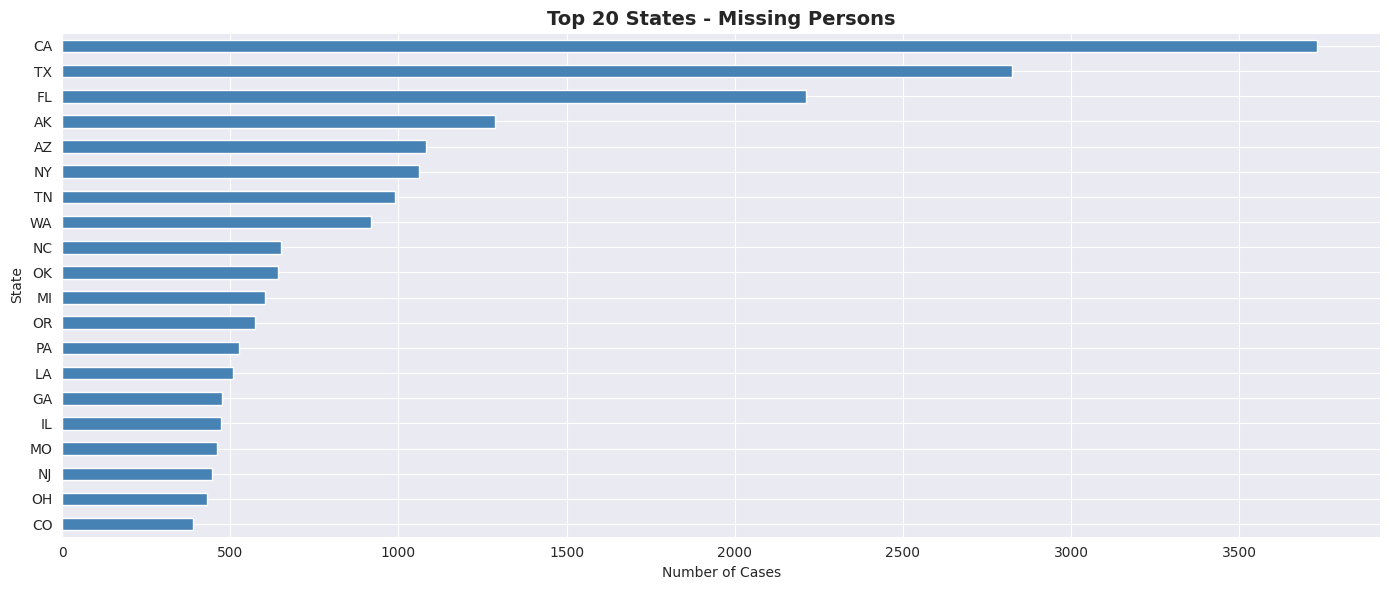


Top 5 states (Missing Persons):
  CA: 3,732
  TX: 2,824
  FL: 2,212
  AK: 1,287
  AZ: 1,082


In [6]:
# Top states by missing persons
mp_by_state = df_mp.groupby('State').size().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(14, 6))
mp_by_state.head(20).plot(kind='barh', ax=ax, color='steelblue')
ax.set_title('Top 20 States - Missing Persons', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of Cases')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\nTop 5 states (Missing Persons):")
for state, count in mp_by_state.head().items():
    print(f"  {state}: {count:,}")

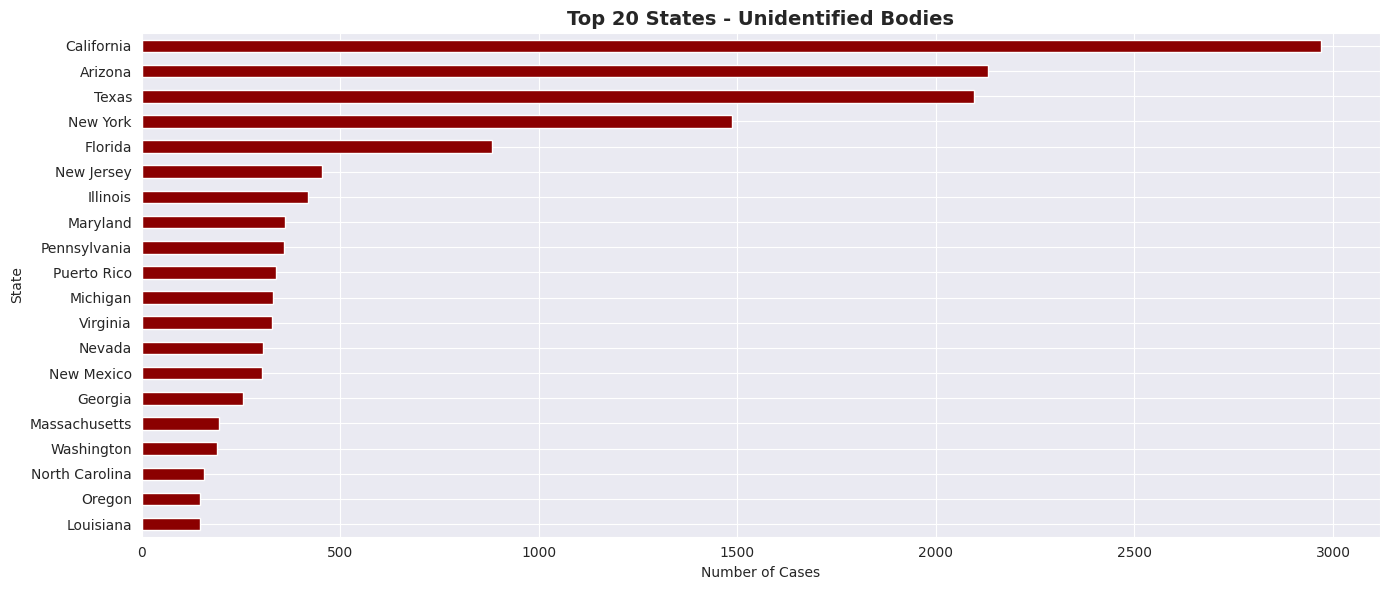


Top 5 states (Unidentified Bodies):
  California: 2,970
  Arizona: 2,131
  Texas: 2,095
  New York: 1,486
  Florida: 883


In [7]:
# Top states by unidentified bodies
bodies_by_state = df_bodies.groupby('State').size().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(14, 6))
bodies_by_state.head(20).plot(kind='barh', ax=ax, color='darkred')
ax.set_title('Top 20 States - Unidentified Bodies', fontsize=14, fontweight='bold')
ax.set_xlabel('Number of Cases')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\nTop 5 states (Unidentified Bodies):")
for state, count in bodies_by_state.head().items():
    print(f"  {state}: {count:,}")

### Temporal distribution

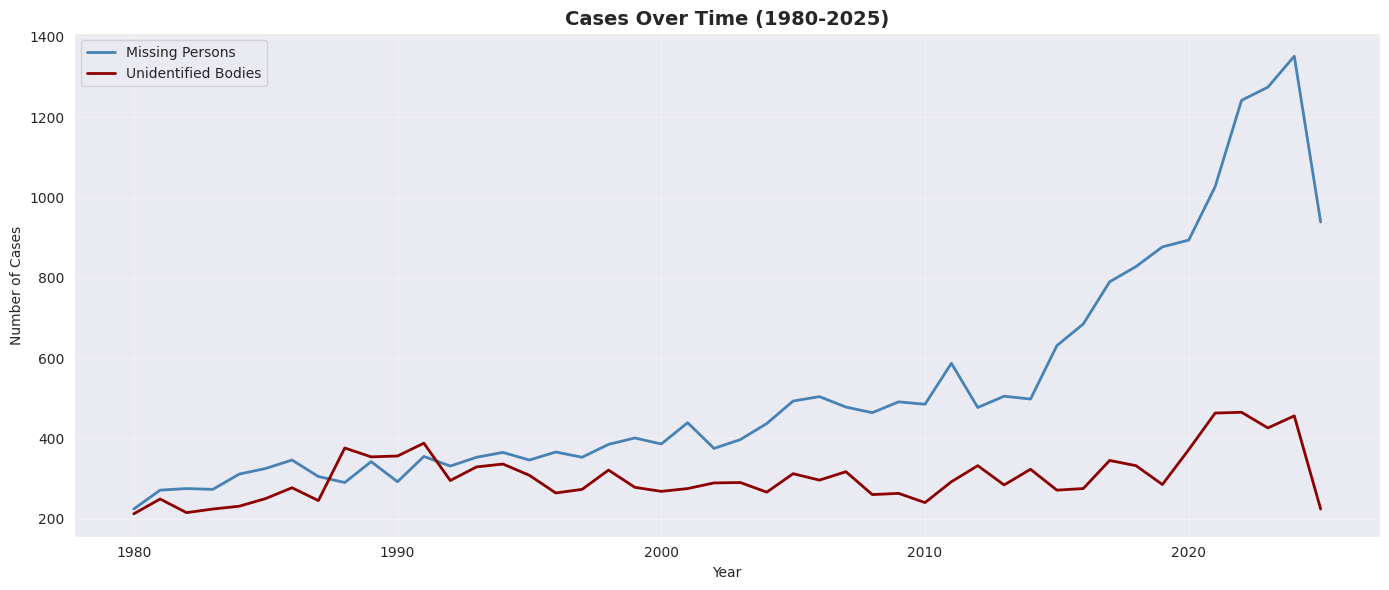

In [8]:
# Cases per year
mp_by_year = df_mp[df_mp['year'] >= 1980].groupby('year').size()
bodies_by_year = df_bodies[df_bodies['year'] >= 1980].groupby('year').size()

fig, ax = plt.subplots(figsize=(14, 6))
mp_by_year.plot(ax=ax, label='Missing Persons', color='steelblue', linewidth=2)
bodies_by_year.plot(ax=ax, label='Unidentified Bodies', color='darkred', linewidth=2)
ax.set_title('Cases Over Time (1980-2025)', fontsize=14, fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Cases')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Decade aggregation

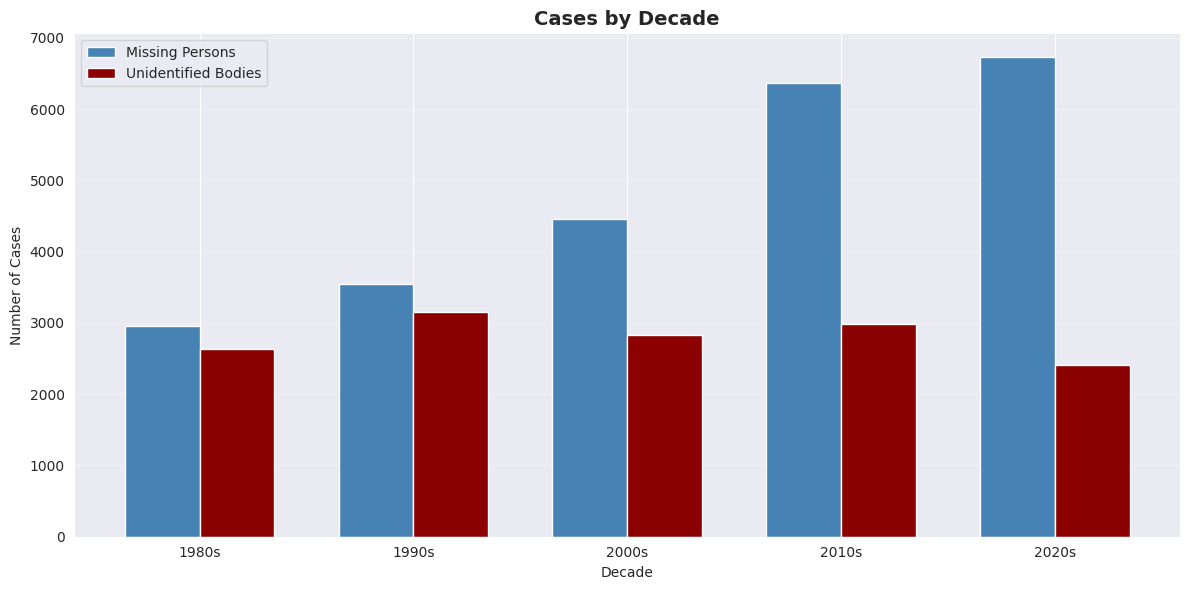

In [9]:
# Add decade column
df_mp['decade'] = (df_mp['year'] // 10) * 10
df_bodies['decade'] = (df_bodies['year'] // 10) * 10

# Cases per decade
mp_by_decade = df_mp[df_mp['decade'] >= 1980].groupby('decade').size()
bodies_by_decade = df_bodies[df_bodies['decade'] >= 1980].groupby('decade').size()

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(mp_by_decade))
width = 0.35

ax.bar(x - width/2, mp_by_decade.values, width, label='Missing Persons', color='steelblue')
ax.bar(x + width/2, bodies_by_decade.values, width, label='Unidentified Bodies', color='darkred')

ax.set_title('Cases by Decade', fontsize=14, fontweight='bold')
ax.set_xlabel('Decade')
ax.set_ylabel('Number of Cases')
ax.set_xticks(x)
ax.set_xticklabels([f"{int(d)}s" for d in mp_by_decade.index])
ax.legend()
ax.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 4. County-Level Analysis

Aggregate to county-decade level for outlier detection

In [10]:
# Aggregate missing persons by county-decade
mp_county_decade = df_mp.groupby(['State', 'County', 'decade']).size().reset_index(name='mp_count')

print(f"County-decade combinations (MP): {len(mp_county_decade):,}")
print(f"\nTop 10 county-decades (Missing Persons):")
print(mp_county_decade.sort_values('mp_count', ascending=False).head(10))

County-decade combinations (MP): 6,238

Top 10 county-decades (Missing Persons):
     State       County  decade  mp_count
5317    TX       Harris    2020       401
5246    TX       Dallas    2020       367
608     CA  Los Angeles    2010       267
609     CA  Los Angeles    2020       223
496     AZ         Pima    2000       157
5332    TX      Hidalgo    2010       153
497     AZ         Pima    2010       151
606     CA  Los Angeles    1990       140
605     CA  Los Angeles    1980       138
607     CA  Los Angeles    2000       129


In [11]:
# Aggregate bodies by county-decade
bodies_county_decade = df_bodies.groupby(['State', 'County', 'decade']).size().reset_index(name='bodies_count')

print(f"County-decade combinations (Bodies): {len(bodies_county_decade):,}")
print(f"\nTop 10 county-decades (Unidentified Bodies):")
print(bodies_county_decade.sort_values('bodies_count', ascending=False).head(10))

County-decade combinations (Bodies): 2,966

Top 10 county-decades (Unidentified Bodies):
            State       County  decade  bodies_count
116       Arizona         Pima    2010           529
117       Arizona         Pima    2020           354
253    California  Los Angeles    1980           341
115       Arizona         Pima    2000           312
1701     New York     New York    1990           258
254    California  Los Angeles    1990           241
2291        Texas       Brooks    2010           231
2150  Puerto Rico          All    2010           221
1682     New York        Kings    1990           169
2292        Texas       Brooks    2020           157


## 5. Data Quality Summary

Final dataset characteristics

In [12]:
print("FINAL DATASET SUMMARY")
print("="*60)
print(f"\nMissing Persons:")
print(f"  Total cases: {len(df_mp):,}")
print(f"  States: {df_mp['State'].nunique()}")
print(f"  Counties: {df_mp['County'].nunique():,}")
print(f"  Year range: {df_mp['year'].min():.0f} - {df_mp['year'].max():.0f}")
print(f"  Decades covered: {sorted(df_mp['decade'].dropna().unique())}")

print(f"\nUnidentified Bodies:")
print(f"  Total cases: {len(df_bodies):,}")
print(f"  States: {df_bodies['State'].nunique()}")
print(f"  Counties: {df_bodies['County'].nunique():,}")
print(f"  Year range: {df_bodies['year'].min():.0f} - {df_bodies['year'].max():.0f}")
print(f"  Decades covered: {sorted(df_bodies['decade'].dropna().unique())}")

print(f"\nCombined:")
print(f"  Total cases: {len(df_mp) + len(df_bodies):,}")
print(f"  Temporal coverage: {df_mp['year'].max() - df_mp['year'].min():.0f} years")
print(f"  Geographic coverage: {max(df_mp['State'].nunique(), df_bodies['State'].nunique())} states/territories")

FINAL DATASET SUMMARY

Missing Persons:
  Total cases: 25,743
  States: 55
  Counties: 1,409
  Year range: 1902 - 2025
  Decades covered: [np.int32(1900), np.int32(1910), np.int32(1920), np.int32(1930), np.int32(1940), np.int32(1950), np.int32(1960), np.int32(1970), np.int32(1980), np.int32(1990), np.int32(2000), np.int32(2010), np.int32(2020)]

Unidentified Bodies:
  Total cases: 15,457
  States: 54
  Counties: 932
  Year range: 1915 - 2025
  Decades covered: [np.int32(1910), np.int32(1920), np.int32(1930), np.int32(1940), np.int32(1950), np.int32(1960), np.int32(1970), np.int32(1980), np.int32(1990), np.int32(2000), np.int32(2010), np.int32(2020)]

Combined:
  Total cases: 41,200
  Temporal coverage: 123 years
  Geographic coverage: 55 states/territories


## Key Findings

1. **Data completeness:** 100% state coverage (54 states/territories)
2. **Temporal range:** 101 years (1924-2025)
3. **Scale:** 41,200 total cases
4. **Missing data:** Minimal year data missing (<5%)
5. **Top states:** CA, TX, FL, AZ (consistent across both datasets)

**Next steps:**
- Calculate standard deviation scores (notebook 02)
- Identify county-decade outliers
- Validate against known serial killer cases